In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
from pygimli.physics import ert
import meshop
import coupleinv2 as CF
import pygimli.physics.traveltime as tt
import petrorelationship as petroship
import matplotlib.pylab as pylab
from kill import kill
from IPython.display import clear_output  

params = {'legend.fontsize': 15,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 12,
         'axes.titlesize':14,
         'xtick.labelsize':12,
         'ytick.labelsize':12}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

17/06/22 - 00:10:02 - pyGIMLi - INFO - Found 2 regions.
17/06/22 - 00:10:02 - pyGIMLi - INFO - Region with smallest marker (1) set to background
17/06/22 - 00:10:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/06/22 - 00:10:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/06/22 - 00:10:02 - pyGIMLi - INFO - Found 1 regions.


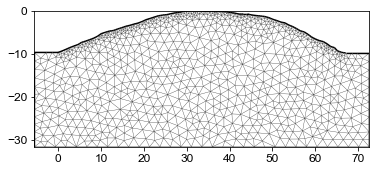

In [2]:
%matplotlib inline
ertData = ert.load('fielddataline1.dat')
ertData['a'] = ertData['a']+1
ertData['b'] = ertData['b']+1
ertData['m'] = ertData['m']+1
ertData['n'] = ertData['n']+1
ert1 = ert.ERTManager(ertData)
grid = ert1.createMesh(data=ertData,quality=30,paraDX=0.5, paraMaxCellSize=3, boundaryMaxCellSize=3000,
                       smooth=[2, 2], paraBoundary=5.5, paraDepth = 22.0)
ert1.setMesh(grid)
mesh = ert1.fop.paraDomain
mesh.setCellMarkers(np.ones((mesh.cellCount()))*2)
pg.show(mesh)

ttData = tt.load("srtfieldline1.dat") # You can change the data file name
TT = pg.physics.traveltime.TravelTimeManager()
TT.setMesh(mesh)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x22a983eb4f0>)

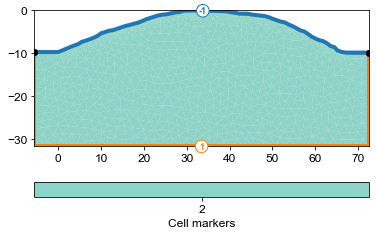

In [3]:
pg.show(mesh,markers=True)

17/06/22 - 00:10:03 - pyGIMLi - ERROR - <class 'pygimli.physics.traveltime.TravelTimeManager.TravelTimeManager'>.checkError(C:\Users\hangchen\Anaconda3\envs\pg\lib\site-packages\pygimli\physics\traveltime\TravelTimeManager.py:87)
DataContainer has no "err" values. Fallback to 3%
17/06/22 - 00:10:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/06/22 - 00:10:03 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
17/06/22 - 00:10:03 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
17/06/22 - 00:10:03 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00110152 0.00100566 0.0006914  ... 0.00020551 0.00020592 0.0002151 ]
17/06/22 - 00:10:03 - pyGIMLi - INFO - Starting inversion.
17/06/22 - 00:10:03 - pyGIMLi - INFO - Setting starting model as reference!


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x0000022A971B9220>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000022A971AB1D0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000022A984B2640>
min/max (data): 0.0058/0.052
min/max (error): 3%/3%
min/max (start model): 2.0e-04/0.0020
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 24.14 (dPhi = 38.92%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 15.94 (dPhi = 28.89%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 13.64 (dPhi = 13.92%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 11.86 (dPhi = 11.86%) lam: 50.0
-------------

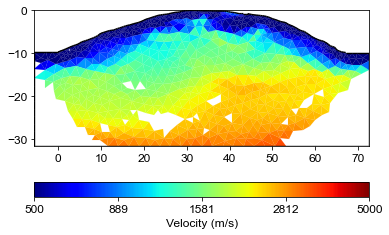

In [4]:

TT.invert(ttData, lam=50,
          zWeight=0.2,vTop=500, vBottom=5000,
          verbose=1, limits=[300., 6000.],isReference=True)

ax, cbar = TT.showResult(cMap='jet',coverage=TT.standardizedCoverage(),cMin=500,cMax=5000)

In [5]:
print(np.mean(abs(TT.inv.response-TT.inv.dataVals)/TT.inv.dataVals))

0.04134997170092221


In [6]:
print(np.sqrt(np.mean((TT.inv.response-TT.inv.dataVals)**2)))

0.0012168051910135939


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x22a971674c0>)

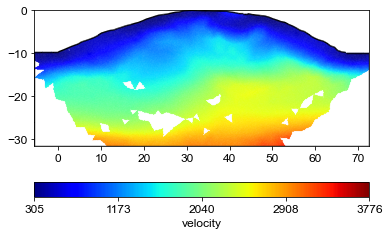

In [7]:
# generate a denser mesh
%matplotlib inline
geo = pg.meshtools.createParaMeshPLC(ertData, quality=34, paraMaxCellSize=0.1,
                                         paraBoundary=5.5,
                                         boundary=0, paraDepth = 22.0)

meshall = pg.meshtools.createMesh(geo,quality=34,area=0.03, smooth=[2, 2], paraBoundary=5.5, paraDepth = 22.0)

out = meshop.linear_interpolation(TT.paraDomain, TT.model.array(), meshall)
out = out.array()
# out = meshop.nearest_neighbor_interpolation(TT.paraDomain, TT.model.array(), meshall)
# out = np.array(out)
Cvout= meshop.nearest_neighbor_interpolation(TT.paraDomain, TT.standardizedCoverage(), meshall)

pg.show(meshall,out,cMap='jet',coverage=Cvout,label='velocity')


In [8]:
meshall.save('fieldvelmesh1')
np.save('fieldVinvmodel1',out)
np.save('fieldVsensmodel1',Cvout)

In [9]:

meshall = pg.load('fieldvelmesh1.bms')
out = np.load('fieldVinvmodel1.npy')
Cvout = np.load('fieldVsensmodel1.npy')

In [10]:
%matplotlib auto
pg.show(meshall,out,cMap='jet',coverage=Cvout,label='velocity')

Using matplotlib backend: <object object at 0x0000022AE2876BB0>


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x22aa8ac3d60>)

In [11]:
# set up the horizontal position and depth to see the velocity distribution
%matplotlib auto
Xpos = [30,32,35]
Depth =[-25,-25,-25]
xyzpos = CF.sepcificline(meshall,out,Xpos,Depth)

Using matplotlib backend: QtAgg


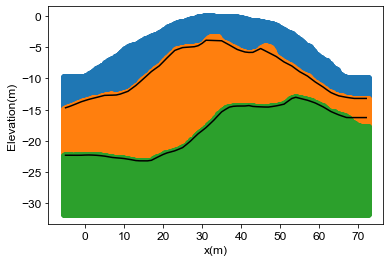

9.005050361397977
9.037191129129045


In [37]:
%matplotlib inline
# select the specific value to do the geophysical zonation
value1 = 1000
value2 = 1950

# set the sections and interval to automatically pick up boundary
firstarea_section = [-5,70]
secondarea_section = [-5,70]
interval = 2

Cvout = np.array(Cvout)
Cvout = np.ones(Cvout.shape)
# set the boundary interpolation range

nrangeinte = np.arange(ttData.sensors().array()[0][0],ttData.sensors().array()[-1][0],1)
nrangeinte = np.hstack((nrangeinte,ttData.sensors().array()[-1][0]))
loc1new,loc2new = CF.boundary(out,Cvout,xyzpos,value1,value2,firstarea_section,secondarea_section,interval,nrangeinte)

np.save('fieldline1_1',loc1new)
np.save('fieldline2_1',loc2new)
# np.save('fieldline1_1100',loc1new)
# np.save('fieldline1_1850',loc2new)
print(np.mean(abs(loc1new-loc2new)))
print(np.median(abs(loc1new-loc2new)))

In [13]:
%matplotlib auto
# select the specific value to do the geophysical zonation
value1 = 1100
value2 = 1950

# set the sections and interval to automatically pick up boundary
firstarea_section = [-5,70]
secondarea_section = [-5,70]
interval = 2

Cvout = np.array(Cvout)
Cvout = np.ones(Cvout.shape)
# set the boundary interpolation range

nrangeinte = np.arange(ttData.sensors().array()[0][0],ttData.sensors().array()[-1][0],1)
nrangeinte = np.hstack((nrangeinte,ttData.sensors().array()[-1][0]))
loc1new,loc2new = CF.boundary(out,Cvout,xyzpos,value1,value2,firstarea_section,secondarea_section,interval,nrangeinte)

Using matplotlib backend: QtAgg


In [14]:
np.save('fieldlinex1',nrangeinte)
np.save('fieldline1_1',loc1new)
np.save('fieldline2_1',loc2new)

In [15]:
markerall,meshafter = CF.constraintinvpara(ertData,nrangeinte,loc1new,loc2new,paraBoundary=5.5)
pg.show(meshafter,markerall)

np.save('fieldmarkerall1',markerall)

17/06/22 - 00:10:32 - pyGIMLi - INFO - Save RVector binary
17/06/22 - 00:10:32 - pyGIMLi - INFO - Cache stored: C:\Users\hangchen\AppData\Roaming\pygimli\Cache\14986749990271282111


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x22b327e4b50>)

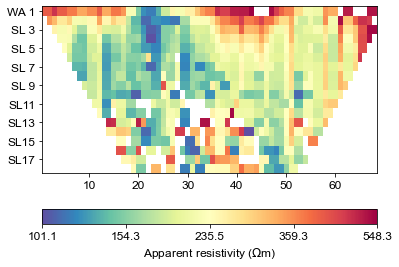

In [16]:
%matplotlib inline
ertData['k'] = ert.createGeometricFactors(ertData, numerical=True)
ertData['rhoa'] = ertData['k']*ertData['u']/ertData['i']

rr = ertData['rhoa']
rr[rr<100]=0
rr[rr>550]=0
ertData['rhoa'] = rr

ertData.save('test1.dat')
ertData.load('test1.dat')
ert1.checkData(ertData)
ert.show(ertData)

In [17]:
ertData['err'] = ert1.estimateError(ertData, 
                                absoluteUError=0.0000, # 50µV
                                relativeError=0.06)  # 3%

# do the contrained inversion
mgrConstrained = ert.ERTManager()
mgrConstrained.invert(data=ertData, verbose=True, lam=5, mesh=meshafter,limits=[50., 10000.])


# do the uncontrained inversion for comparison
mgrnoConstrained = ert.ERTManager()
mgrnoConstrained.invert(data=ertData, lam=5, paraDepth = 22.0,
                         paraDX=0.5, paraMaxCellSize=5, verbose=True,paraBoundary=5.5,limits=[50., 10000.])


17/06/22 - 00:10:33 - pyGIMLi - INFO - Found 2 regions.
17/06/22 - 00:10:33 - pyGIMLi - INFO - Region with smallest marker (1) set to background
17/06/22 - 00:10:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/06/22 - 00:10:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/06/22 - 00:10:33 - pyGIMLi - INFO - Use median(data values)=217.7569293940075
17/06/22 - 00:10:33 - pyGIMLi - INFO - Created startmodel from forward operator: 2293 [217.7569293940075,...,217.7569293940075]
17/06/22 - 00:10:33 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000022B328C6B30>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000022B328C6CC0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000022B32885B20>
min/max (data): 101/548
min/max (error): 6%/6%
min/max (start model): 218/218
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 9.14 (dPhi = 9.21%) lam: 5.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 9.0 (dPhi = 0.91%) lam: 5.0
--------------------------------------------------------------------------------
inv.iter 4 ... 

17/06/22 - 00:11:01 - pyGIMLi - INFO - Found 2 regions.
17/06/22 - 00:11:01 - pyGIMLi - INFO - Region with smallest marker (1) set to background
17/06/22 - 00:11:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/06/22 - 00:11:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/06/22 - 00:11:01 - pyGIMLi - INFO - Use median(data values)=217.7569293940075
17/06/22 - 00:11:01 - pyGIMLi - INFO - Created startmodel from forward operator: 1465 [217.7569293940075,...,217.7569293940075]
17/06/22 - 00:11:01 - pyGIMLi - INFO - Starting inversion.


chi² = 9.0 (dPhi = 0.1%) lam: 5.0
################################################################################
#                 Abort criteria reached: dPhi = 0.1 (< 2.0%)                  #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000022AA8B38900>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000022B328C66D0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000022B328D82E0>
min/max (data): 101/548
min/max (error): 6%/6%
min/max (start model): 218/218
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 9.08 (dPhi = 7.7%) lam: 5.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 9.01 (dPhi = 0.4%) lam: 5.0
----------------------------------------

1465 [707.8372840470095,...,607.7048010332802]

0.10965256837511794

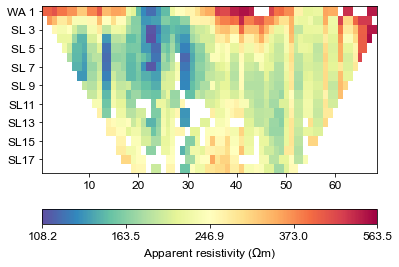

In [18]:
ert.show(ertData,mgrConstrained.inv.response)
np.mean(abs(ertData['rhoa'] - mgrConstrained.inv.response)/(ertData['rhoa']))

(<AxesSubplot:xlabel='x (m)', ylabel='z (m)'>,
 <matplotlib.colorbar.Colorbar at 0x22b32e9b490>)

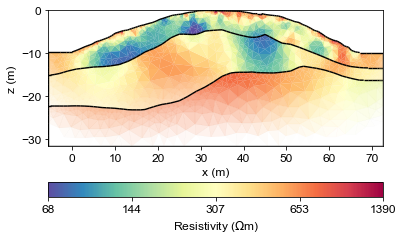

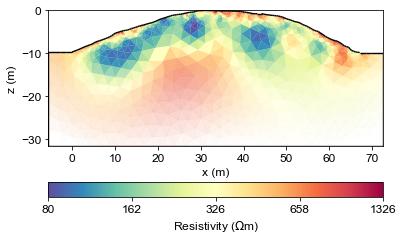

In [19]:
%matplotlib inline
mgrConstrained.showResult(xlabel="x (m)", ylabel="z (m)",coverage = mgrConstrained.coverage())
mgrnoConstrained.showResult(xlabel="x (m)", ylabel="z (m)",coverage = mgrnoConstrained.coverage())

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x22b330809a0>)

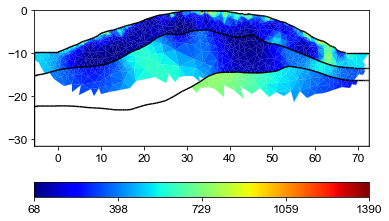

In [20]:
%matplotlib inline
Mall = np.array(mgrConstrained.paraModel())
sens = mgrConstrained.coverage()
mgrConstrained.paraDomain.save('fieldconstaintmesh1')
np.save('fieldconstaintmodel1',Mall)
np.save('fieldconstaintsens1',sens)
sens[sens<-1.3]=-10000
# pg.show(mgrConstrained.paraDomain,sens,cMap='jet')
pg.show(mgrConstrained.paraDomain,Mall,cMap='jet',coverage=sens)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x22b3472f9a0>)

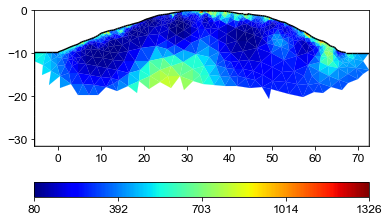

In [21]:
%matplotlib inline
Mall2 = np.array(mgrnoConstrained.paraModel())
sens2 = mgrnoConstrained.coverage()
mgrnoConstrained.paraDomain.save('fieldnoconstaintmesh1')
np.save('fieldnoconstaintmodel1',Mall2)
np.save('fieldnoconstaintsens1',sens2)
np.save('fieldmarkerall1',markerall)
sens2[sens2<-1.3]=-10000
pg.show(mgrnoConstrained.paraDomain,Mall2,cMap='jet',coverage=sens2)

## MC sampling for water content¶
You can start directly here if you already have resistivity inversion results

In [22]:
noconstaintmesh = pg.load('fieldnoconstaintmesh1.bms')
noconstaintmodel = np.load('fieldnoconstaintmodel1.npy')
noconstaintsens = np.load('fieldnoconstaintsens1.npy')

constaintmesh = pg.load('fieldconstaintmesh1.bms')
constaintmodel = np.load('fieldconstaintmodel1.npy')
constaintsens = np.load('fieldconstaintsens1.npy')

markerall = np.load('fieldmarkerall1.npy')

In [23]:
print(constaintmesh.cellCount())

markerall2 = markerall[markerall!=1].copy()
markerall2.shape

2293


(2293,)

In [24]:
petrorange = petroship.petrorange
# petrorange.porosity = [0.45, 0.3, 0.1, 0.35, 0.02, 0.1]
# petrorange.m_model = [1.4, 2.2, 1.0, 1.5, 1.6, 2.5]
petrorange.porosity = [0.5, 0.25, 0.3, 0.2, 0.05, 0.15]
petrorange.n_model = [2.2, 1.3, 2.2, 2.0, 2.0, 2.0]
petrorange.rhos = [100/2, 500/2, 330/2, 700/2, 650/2, 2000/2]
petrorange.sigmas = [1/400, 1/3200, 0, 0, 0, 0]


petrorange.a_model = 1.0
iter1 = 10000





In [25]:


modelsall,modelsall2  = CF.petroMC(iter1, constaintmesh.cellCount(),
           petrorange,markerall,constaintmodel)


C:\Users\hangchen\Documents\Hang\couple\Hydrogeo_inv_seq\test2\petrorelationship.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  solution = np.array(solution)
C:\Users\hangchen\Documents\Hang\couple\Hydrogeo_inv_seq\test2\petrorelationship.py:52: RuntimeWarning: invalid value encountered in power
  func = lambda SS : sigma_sat[i]*SS**n[i] + sigma_sur[i]*SS**(n[i]-1) - 1/rho[i]
C:\Users\hangchen\Anaconda3\envs\pg\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [26]:

tradmodelsall,tradmodelsall2  = CF.petroMCtt(iter1,noconstaintmesh.cellCount(),petrorange,noconstaintmodel)

0.05996985210017848


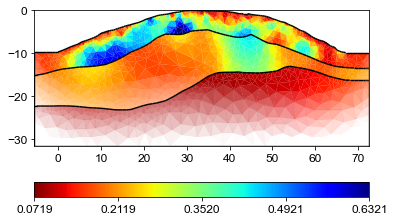

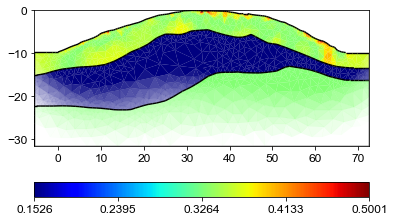

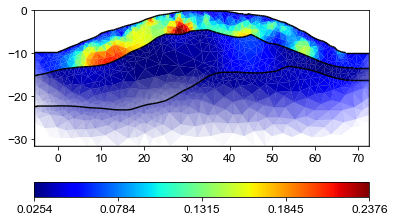

In [27]:
%matplotlib inline
pg.show(constaintmesh,np.mean(modelsall,axis=0),cMap='jet_r',coverage=constaintsens)
pg.show(constaintmesh,np.std(modelsall,axis=0)/np.mean(modelsall,axis=0),cMap='jet',coverage=constaintsens)
pg.show(constaintmesh,np.std(modelsall,axis=0),cMap='jet',coverage=constaintsens)
print(np.mean(np.std(modelsall,axis=0)))
np.mean(np.std(modelsall,axis=0)/np.mean(modelsall,axis=0))

np.save('fieldconstaintWC1',modelsall)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x22b32b673d0>)

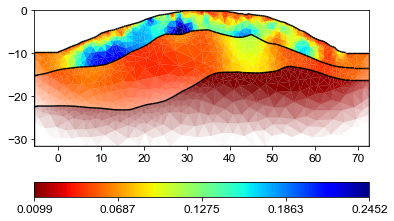

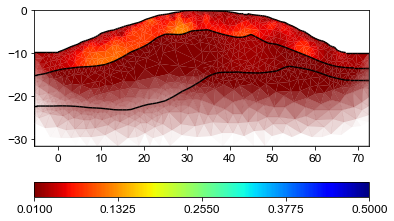

In [28]:
pg.show(constaintmesh,np.mean(modelsall*modelsall2,axis=0),cMap='jet_r',coverage=constaintsens)
#pg.show(constaintmesh,np.std(modelsall*modelsall2,axis=0)/np.mean(modelsall*modelsall2,axis=0),cMap='jet_r',coverage=sens)
pg.show(constaintmesh,np.std(modelsall*modelsall2,axis=0),cMap='jet_r',coverage=constaintsens,cMin = 0.01, cMax = 0.5)

0.0793450041727094


0.3505671615196492

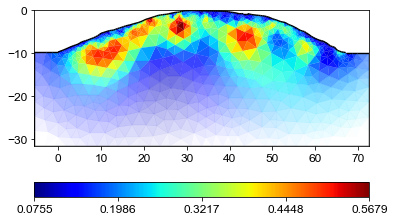

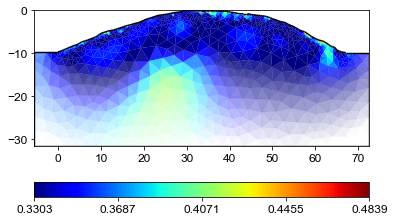

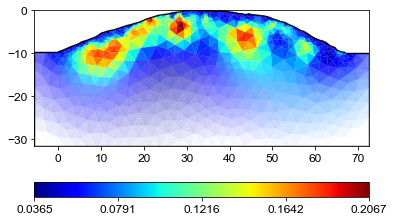

In [29]:
pg.show(noconstaintmesh,np.mean(tradmodelsall,axis=0),cMap='jet',coverage=noconstaintsens)
pg.show(noconstaintmesh,np.std(tradmodelsall,axis=0)/np.mean(tradmodelsall,axis=0),cMap='jet',coverage=noconstaintsens)
pg.show(noconstaintmesh,np.std(tradmodelsall,axis=0),cMap='jet',coverage=noconstaintsens)
print(np.mean(np.std(tradmodelsall,axis=0)))
np.mean(np.std(tradmodelsall,axis=0)/np.mean(tradmodelsall,axis=0))


In [30]:
np.save('fieldnoconstaintWC1',tradmodelsall)

In [31]:
tradmodelsall.shape

(10000, 1465)